**Training Deep Neural Nets**

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

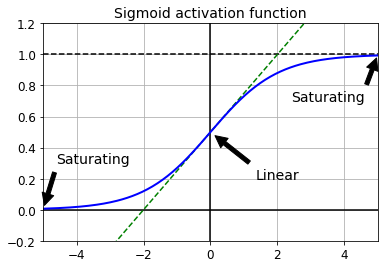

In [2]:
# Logit / Sigmoid function plot

def logit(z):
    return 1 / (1 + np.exp(-z))


z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

## He Initialization

In [3]:
import tensorflow as tf

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

/usr/local/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Nonsaturating Activation Functions

### Leaky ReLU

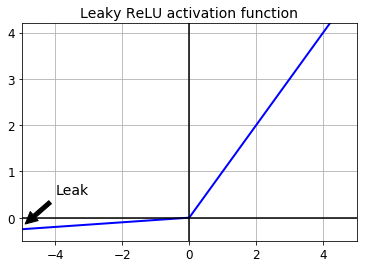

In [4]:
# Leaky ReLU plot 

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [5]:
# Implementing Leaky ReLU in TensorFlow

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

## Let's train a neural network on MNIST using the Leaky ReLU

### Step 1- First let's create the graph

In [6]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [7]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [8]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [9]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [10]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [11]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Step 2- Now let's load the data

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [14]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_test = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9018
5 Batch accuracy: 0.92 Validation accuracy: 0.9486
10 Batch accuracy: 0.98 Validation accuracy: 0.9634
15 Batch accuracy: 1.0 Validation accuracy: 0.9706
20 Batch accuracy: 1.0 Validation accuracy: 0.9746
25 Batch accuracy: 1.0 Validation accuracy: 0.976
30 Batch accuracy: 1.0 Validation accuracy: 0.978
35 Batch accuracy: 0.96 Validation accuracy: 0.9784


### ELU

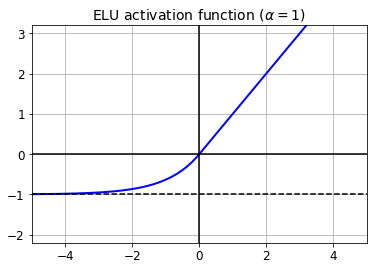

In [15]:
# ELU plot

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [16]:
# Implementing ELU in TensorFlow
# Just specify the activation function when building each layer
    
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I will definitely add it to the book). It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

In [17]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

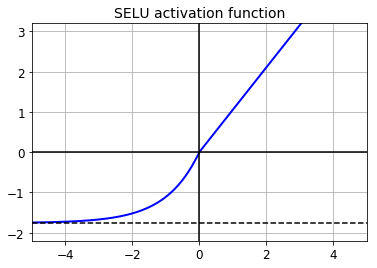

In [18]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

In [19]:
# Check the mean and standard deviation in the deep layers for SELU activation function

np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


### Let's create a neural net for MNIST using the SELU activation function

In [20]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [21]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.validation.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.validation.labels})
            print(epoch, "Batch accuracy:", acc_train, "Validation accuracy:", acc_test)

    save_path = saver.save(sess, "model_ckps/my_model_final_selu.ckpt")

0 Batch accuracy: 0.96 Validation accuracy: 0.9244
5 Batch accuracy: 1.0 Validation accuracy: 0.9582
10 Batch accuracy: 0.96 Validation accuracy: 0.9658
15 Batch accuracy: 0.92 Validation accuracy: 0.9672
20 Batch accuracy: 1.0 Validation accuracy: 0.9708
25 Batch accuracy: 1.0 Validation accuracy: 0.9712
30 Batch accuracy: 1.0 Validation accuracy: 0.972
35 Batch accuracy: 1.0 Validation accuracy: 0.972


# Batch Normalization

In [22]:
# Let's implement Batch Normalization with TensorFlow

reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

# Set Training. Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder)
# Whether to return the output in training mode (normalized with statistics of the current batch) 
# or in inference mode (normalized with moving statistics)

training = tf.placeholder_with_default(False, shape=(), name='training')


hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")

# We will discuss momentum later in the course

bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [23]:
# In previous example, we passed parameters repeatedly to batch_normalization function
# To avoid repeating the same parameters over and over again, we can use Python's partial() function 
# Let's improve previous example with partial() 

from functools import partial


reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [24]:
# Now let's build a neural net for MNIST
# Using the ELU activation function and Batch Normalization at each layer

reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.contrib.layers.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
# Execution phase

n_epochs = 20
batch_size = 200

# When is_training is True the moving_mean and moving_variance need to be updated by running these commands
# extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# sess.run([train_op, extra_update_ops], ...)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.8738
1 Test accuracy: 0.8976
2 Test accuracy: 0.9108
3 Test accuracy: 0.9208
4 Test accuracy: 0.9287
5 Test accuracy: 0.9352
6 Test accuracy: 0.9406
7 Test accuracy: 0.9444
8 Test accuracy: 0.947
9 Test accuracy: 0.9491
10 Test accuracy: 0.953
11 Test accuracy: 0.9542
12 Test accuracy: 0.9572
13 Test accuracy: 0.959
14 Test accuracy: 0.9602
15 Test accuracy: 0.9605
16 Test accuracy: 0.9618
17 Test accuracy: 0.9633
18 Test accuracy: 0.9636
19 Test accuracy: 0.9644


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [26]:
# List trainable variables

[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [27]:
# List global variables

[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping

In [35]:
# Create a simple neural net for MNIST and add gradient clipping

reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [36]:
# Now we apply gradient clipping.
# For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them

learning_rate = 0.01

threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [39]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.5127
1 Test accuracy: 0.8305
2 Test accuracy: 0.8825
3 Test accuracy: 0.9033
4 Test accuracy: 0.9145
5 Test accuracy: 0.9234
6 Test accuracy: 0.9315
7 Test accuracy: 0.9348
8 Test accuracy: 0.9385
9 Test accuracy: 0.9434
10 Test accuracy: 0.9423
11 Test accuracy: 0.9481
12 Test accuracy: 0.9503
13 Test accuracy: 0.9525
14 Test accuracy: 0.9533
15 Test accuracy: 0.9553
16 Test accuracy: 0.9579
17 Test accuracy: 0.959
18 Test accuracy: 0.9593
19 Test accuracy: 0.9611


## Reusing Pretrained Layers

## Reusing a TensorFlow Model

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [45]:
reset_graph()

In [46]:
saver = tf.train.import_meta_graph("model_ckps/my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [47]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/Const
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/Const
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [48]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [49]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [50]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [51]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [52]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [53]:
with tf.Session() as sess:
    saver.restore(sess, "model_ckps/my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [54]:
with tf.Session() as sess:
    saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9609
1 Test accuracy: 0.9608
2 Test accuracy: 0.9617
3 Test accuracy: 0.9613
4 Test accuracy: 0.9639
5 Test accuracy: 0.9649
6 Test accuracy: 0.9663
7 Test accuracy: 0.9627
8 Test accuracy: 0.9665
9 Test accuracy: 0.9669
10 Test accuracy: 0.9662
11 Test accuracy: 0.9674
12 Test accuracy: 0.9678
13 Test accuracy: 0.9679
14 Test accuracy: 0.9688
15 Test accuracy: 0.9684
16 Test accuracy: 0.9687
17 Test accuracy: 0.9702
18 Test accuracy: 0.9673
19 Test accuracy: 0.9687


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9611
1 Test accuracy: 0.9619
2 Test accuracy: 0.9622
3 Test accuracy: 0.9619
4 Test accuracy: 0.9644
5 Test accuracy: 0.9633
6 Test accuracy: 0.9647
7 Test accuracy: 0.9648
8 Test accuracy: 0.9671
9 Test accuracy: 0.9677
10 Test accuracy: 0.9676
11 Test accuracy: 0.9679
12 Test accuracy: 0.9687
13 Test accuracy: 0.9688
14 Test accuracy: 0.9683
15 Test accuracy: 0.9693
16 Test accuracy: 0.9677
17 Test accuracy: 0.9697
18 Test accuracy: 0.9692
19 Test accuracy: 0.9707


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [57]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("model_ckps/my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [58]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "model_ckps/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9142
1 Test accuracy: 0.9346
2 Test accuracy: 0.9437
3 Test accuracy: 0.9486
4 Test accuracy: 0.9517
5 Test accuracy: 0.9544
6 Test accuracy: 0.9544
7 Test accuracy: 0.9562
8 Test accuracy: 0.9588
9 Test accuracy: 0.9619
10 Test accuracy: 0.9617
11 Test accuracy: 0.9617
12 Test accuracy: 0.9624
13 Test accuracy: 0.9644
14 Test accuracy: 0.9622
15 Test accuracy: 0.964
16 Test accuracy: 0.9666
17 Test accuracy: 0.9668
18 Test accuracy: 0.9673
19 Test accuracy: 0.9687


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [59]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [60]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):                                      # not shown in the book
        for iteration in range(mnist.train.num_examples // batch_size): # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)      # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})  # not shown
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,  # not shown
                                                y: mnist.test.labels}) # not shown
        print(epoch, "Test accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9022
1 Test accuracy: 0.9302
2 Test accuracy: 0.9393
3 Test accuracy: 0.9429
4 Test accuracy: 0.9484
5 Test accuracy: 0.9511
6 Test accuracy: 0.9517
7 Test accuracy: 0.9539
8 Test accuracy: 0.9545
9 Test accuracy: 0.9572
10 Test accuracy: 0.9599
11 Test accuracy: 0.9602
12 Test accuracy: 0.9606
13 Test accuracy: 0.9619
14 Test accuracy: 0.9619
15 Test accuracy: 0.9636
16 Test accuracy: 0.9633
17 Test accuracy: 0.9643
18 Test accuracy: 0.9651
19 Test accuracy: 0.9657


## Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [61]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [62]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[  61.   83.  105.]]


Note: the weights variable created by the `tf.layers.dense()` function is called `"kernel"` (instead of `"weights"` when using the `tf.contrib.layers.fully_connected()`, as in the book), and the biases variable is called `bias` instead of `biases`.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [63]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[  61.   83.  105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [64]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [65]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [66]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Freezing the Lower Layers

In [67]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [68]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [69]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [70]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.8987
1 Test accuracy: 0.9311
2 Test accuracy: 0.9375
3 Test accuracy: 0.9414
4 Test accuracy: 0.9437
5 Test accuracy: 0.9479
6 Test accuracy: 0.9495
7 Test accuracy: 0.9521
8 Test accuracy: 0.9517
9 Test accuracy: 0.9525
10 Test accuracy: 0.9535
11 Test accuracy: 0.9538
12 Test accuracy: 0.9534
13 Test accuracy: 0.9546
14 Test accuracy: 0.9538
15 Test accuracy: 0.9553
16 Test accuracy: 0.9552
17 Test accuracy: 0.9549
18 Test accuracy: 0.9553
19 Test accuracy: 0.9557


In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [72]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [73]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "model_ckps/my_model_final.ckpt")

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9031
1 Test accuracy: 0.932
2 Test accuracy: 0.94
3 Test accuracy: 0.9435
4 Test accuracy: 0.9473
5 Test accuracy: 0.9492
6 Test accuracy: 0.9498
7 Test accuracy: 0.9493
8 Test accuracy: 0.9515
9 Test accuracy: 0.9519
10 Test accuracy: 0.9529
11 Test accuracy: 0.9536
12 Test accuracy: 0.9529
13 Test accuracy: 0.9532
14 Test accuracy: 0.9522
15 Test accuracy: 0.9534
16 Test accuracy: 0.953
17 Test accuracy: 0.955
18 Test accuracy: 0.955
19 Test accuracy: 0.9552


### Caching the Frozen Layers

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [76]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "model_ckps/my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: mnist.train.images})
    h2_cache_test = sess.run(hidden2, feed_dict={X: mnist.test.images}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_test, # not shown
                                                y: mnist.test.labels})  # not shown
        print(epoch, "Test accuracy:", accuracy_val)                    # not shown

    save_path = saver.save(sess, "model_ckps/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Test accuracy: 0.9033
1 Test accuracy: 0.9322
2 Test accuracy: 0.9423
3 Test accuracy: 0.9449
4 Test accuracy: 0.9471
5 Test accuracy: 0.9477
6 Test accuracy: 0.951
7 Test accuracy: 0.9507
8 Test accuracy: 0.9514
9 Test accuracy: 0.9522
10 Test accuracy: 0.9512
11 Test accuracy: 0.9521
12 Test accuracy: 0.9522
13 Test accuracy: 0.9539
14 Test accuracy: 0.9536
15 Test accuracy: 0.9534
16 Test accuracy: 0.9547
17 Test accuracy: 0.9537
18 Test accuracy: 0.9542
19 Test accuracy: 0.9547


# Faster Optimizers

## Momentum optimization

In [78]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

In [79]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [80]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [81]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

In [82]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [83]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [84]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [85]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.9579
1 Test accuracy: 0.9691
2 Test accuracy: 0.976
3 Test accuracy: 0.9793
4 Test accuracy: 0.9811


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [87]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [88]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [89]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [90]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.8343
1 Test accuracy: 0.8726
2 Test accuracy: 0.8832
3 Test accuracy: 0.8899
4 Test accuracy: 0.8958
5 Test accuracy: 0.8986
6 Test accuracy: 0.9011
7 Test accuracy: 0.9032
8 Test accuracy: 0.9046
9 Test accuracy: 0.9047
10 Test accuracy: 0.9065
11 Test accuracy: 0.9059
12 Test accuracy: 0.9072
13 Test accuracy: 0.9072
14 Test accuracy: 0.9069
15 Test accuracy: 0.9071
16 Test accuracy: 0.9064
17 Test accuracy: 0.9071
18 Test accuracy: 0.9068
19 Test accuracy: 0.9063


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [91]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [92]:
scale = 0.001

In [93]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Next we must add the regularization losses to the base loss:

In [94]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [95]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [96]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.8298
1 Test accuracy: 0.8778
2 Test accuracy: 0.8917
3 Test accuracy: 0.9017
4 Test accuracy: 0.9068
5 Test accuracy: 0.9103
6 Test accuracy: 0.9125
7 Test accuracy: 0.9137
8 Test accuracy: 0.9149
9 Test accuracy: 0.9174
10 Test accuracy: 0.9176
11 Test accuracy: 0.9184
12 Test accuracy: 0.9191
13 Test accuracy: 0.9183
14 Test accuracy: 0.9195
15 Test accuracy: 0.9201
16 Test accuracy: 0.9181
17 Test accuracy: 0.9184
18 Test accuracy: 0.9181
19 Test accuracy: 0.9174


## Dropout

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [97]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [98]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [99]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [100]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")

0 Test accuracy: 0.9205
1 Test accuracy: 0.9418
2 Test accuracy: 0.9486
3 Test accuracy: 0.9508
4 Test accuracy: 0.954
5 Test accuracy: 0.957
6 Test accuracy: 0.9604
7 Test accuracy: 0.9585
8 Test accuracy: 0.9598
9 Test accuracy: 0.9663
10 Test accuracy: 0.9644
11 Test accuracy: 0.9646
12 Test accuracy: 0.9675
13 Test accuracy: 0.9657
14 Test accuracy: 0.9645
15 Test accuracy: 0.9668
16 Test accuracy: 0.969
17 Test accuracy: 0.9682
18 Test accuracy: 0.9698
19 Test accuracy: 0.9682


## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [101]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [102]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [103]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [104]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [105]:
n_epochs = 20
batch_size = 50

In [106]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for iteration in range(mnist.train.num_examples // batch_size):  # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)       # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,       # not shown
                                            y: mnist.test.labels})      # not shown
        print(epoch, "Test accuracy:", acc_test)                        # not shown

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")               # not shown

0 Test accuracy: 0.9517
1 Test accuracy: 0.9674
2 Test accuracy: 0.9712
3 Test accuracy: 0.9759
4 Test accuracy: 0.975
5 Test accuracy: 0.9761
6 Test accuracy: 0.9765
7 Test accuracy: 0.9796
8 Test accuracy: 0.9791
9 Test accuracy: 0.9794
10 Test accuracy: 0.9805
11 Test accuracy: 0.9809
12 Test accuracy: 0.9807
13 Test accuracy: 0.9799
14 Test accuracy: 0.982
15 Test accuracy: 0.9816
16 Test accuracy: 0.9825
17 Test accuracy: 0.9825
18 Test accuracy: 0.9816
19 Test accuracy: 0.9822


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [107]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [108]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [109]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [110]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [111]:
n_epochs = 20
batch_size = 50

In [112]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images,     # not shown in the book
                                            y: mnist.test.labels})    # not shown
        print(epoch, "Test accuracy:", acc_test)                      # not shown

    save_path = saver.save(sess, "model_ckps/my_model_final.ckpt")             # not shown

0 Test accuracy: 0.9527
1 Test accuracy: 0.9653
2 Test accuracy: 0.97
3 Test accuracy: 0.9751
4 Test accuracy: 0.9752
5 Test accuracy: 0.9742
6 Test accuracy: 0.9754
7 Test accuracy: 0.9784
8 Test accuracy: 0.9775
9 Test accuracy: 0.9789
10 Test accuracy: 0.9808
11 Test accuracy: 0.9797
12 Test accuracy: 0.9802
13 Test accuracy: 0.9799
14 Test accuracy: 0.9808
15 Test accuracy: 0.9809
16 Test accuracy: 0.9807
17 Test accuracy: 0.9803
18 Test accuracy: 0.9816
19 Test accuracy: 0.9812
